## Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
import cv2
from google.colab import drive

## Import Dataset dan Eksplorasi Data

In [ ]:
drive.mount('/content/drive')
data_folder = "/content/drive/My Drive/BT Dataset"
tumor_types = ["glioma", "meningioma", "pituitary"]

image_paths = []
labels = []

Mounted at /content/drive


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for tumor_type_idx, tumor_type in enumerate(tumor_types, start=1):
        tumor_folder = os.path.join(folder, str(tumor_type_idx))
        for filename in os.listdir(tumor_folder):
            img = Image.open(os.path.join(tumor_folder, filename))
            if img is not None:
                images.append(np.array(img))
                labels.append(tumor_type)
    return images, labels

In [ ]:
images, labels = load_images_from_folder(data_folder)

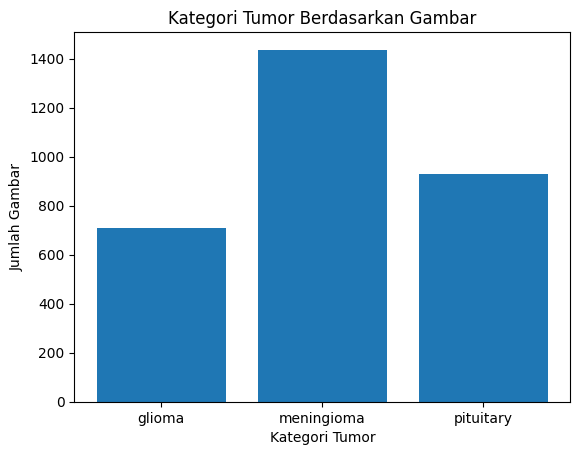

In [ ]:
# Bar Plot Kategori Tumor Berdasarkan Gambar
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Kategori Tumor')
plt.ylabel('Jumlah Gambar')
plt.title('Kategori Tumor Berdasarkan Gambar')
plt.show()

## Preprocessing

In [ ]:
# Convert gambar menjadi format grayscale dan memfilter gambar supaya gambar lebih cepat untuk diproses. soalnya kalo gambarnya ga di filter, proses modelling cnnnya bakal lama nantinya
gray_images = [np.array(Image.fromarray(img).convert("L")) for img in images]
resized_images = [np.array(Image.fromarray(img).resize((128, 128))) for img in gray_images]
low_pass_filtered_images = [cv2.GaussianBlur(img, (5, 5), 0) for img in resized_images]
median_filtered_images = [cv2.medianBlur(img, 5) for img in low_pass_filtered_images]
preprocessed_images = np.array(median_filtered_images).astype("float32") / 255.0

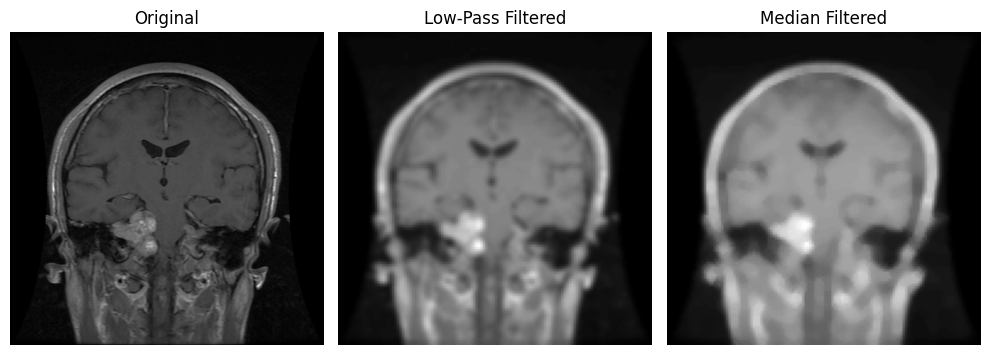

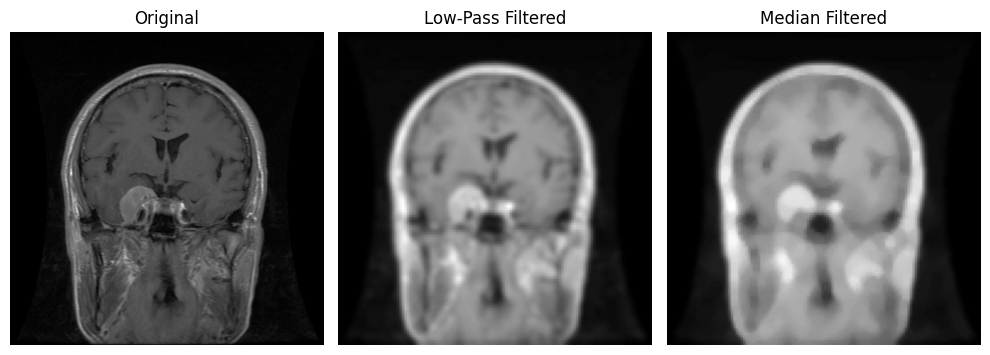

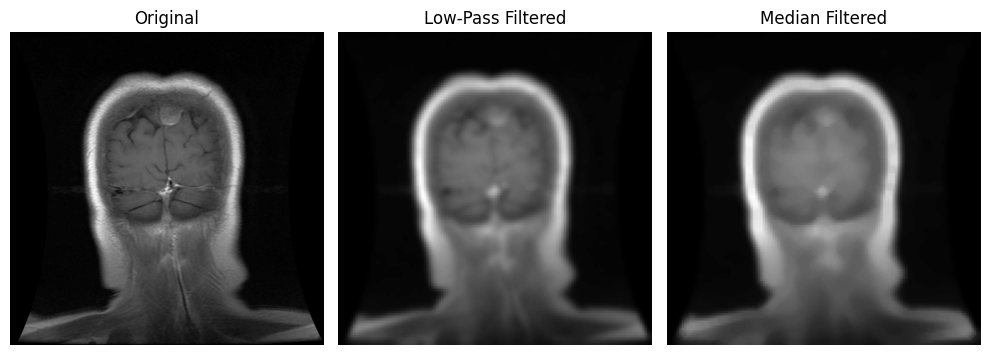

In [ ]:
# Tampilkan gambar original dan gambar yang sudah di low-pass dan median filter
num_images_to_display = 3
for i in range(num_images_to_display):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gray_images[i], cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(low_pass_filtered_images[i], cmap="gray")
    plt.title("Low-Pass Filtered")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(median_filtered_images[i], cmap="gray")
    plt.title("Median Filtered")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Split dataset untuk training dan testing
train_images, test_images, train_labels, test_labels = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42, stratify=labels)

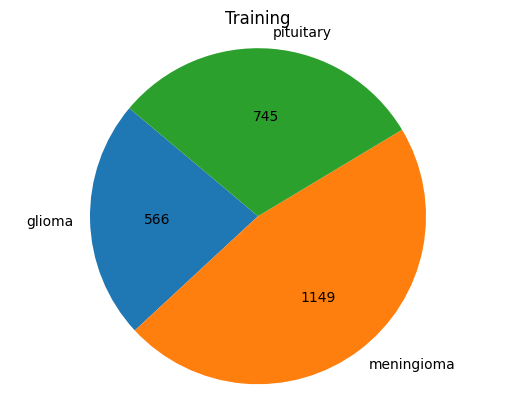

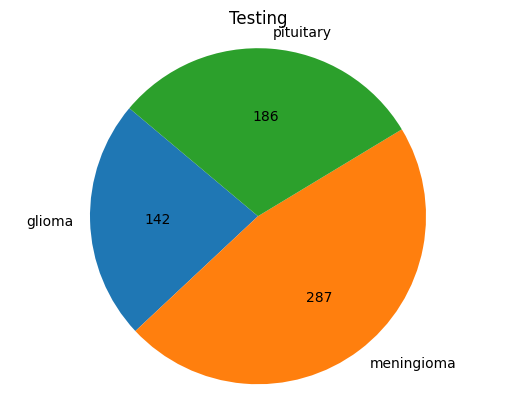

In [ ]:
# Pie chart untuk menunjukan jumlah data yang akan digunakan dalam training dan testing
def plot_pie_chart(labels, title):
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.pie(counts, labels=unique_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100))
    plt.axis('equal')
    plt.title(title)
    plt.show()

plot_pie_chart(train_labels, "Training")
plot_pie_chart(test_labels, "Testing")

In [ ]:
# Modelling CNN

input_shape = (128, 128, 1)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(tumor_types), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Convert label dengan one hot encoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

In [ ]:
# Training Model
model.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 50s 776ms/step - loss: 0.8292 - accuracy: 0.6301 - val_loss: 0.6501 - val_accuracy: 0.7236
Epoch 2/10
62/62 [==============================] - 51s 820ms/step - loss: 0.6108 - accuracy: 0.7282 - val_loss: 0.5247 - val_accuracy: 0.7886
Epoch 3/10
62/62 [==============================] - 48s 768ms/step - loss: 0.4689 - accuracy: 0.8095 - val_loss: 0.4247 - val_accuracy: 0.8333
Epoch 4/10
62/62 [==============================] - 51s 824ms/step - loss: 0.3987 - accuracy: 0.8318 - val_loss: 0.3740 - val_accuracy: 0.8496
Epoch 5/10
62/62 [==============================] - 49s 797ms/step - loss: 0.3156 - accuracy: 0.8791 - val_loss: 0.3801 - val_accuracy: 0.8537
Epoch 6/10
62/62 [==============================] - 49s 784ms/step - loss: 0.3011 - accuracy: 0.8821 - val_loss: 0.3633 - val_accuracy: 0.8557
Epoch 7/10
62/62 [==============================] - 49s 794ms/step - loss: 0.2420 - accuracy: 0.9085 - val_loss: 0.2953 - val_accuracy: 0.9065

## Confusion Matrix

In [ ]:
test_predictions = model.predict(test_images)
test_labels_pred = np.argmax(test_predictions, axis=1)
test_labels_pred

20/20 [==============================] - 5s 219ms/step


array([2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 0, 1, 2,
       1, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 0, 1, 0, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 0,
       0, 1, 0, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2,
       2, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1,
       2, 0, 1, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 1,
       1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1,
       0, 2, 1, 2, 1, 0, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1,

In [ ]:
y_true = pd.DataFrame(test_labels_encoded)
y_pred = pd.DataFrame(test_labels_pred)

In [ ]:
# Menghitung Confusion Matrix
cm = confusion_matrix(test_labels_encoded, test_labels_pred)
class_labels = ['giloma', 'meningioma', 'pituitary']

for i, label in enumerate(class_labels):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    true_positive_rate = TP / (TP + FN)
    true_negative_rate = TN / (TN + FP)
    false_positive_rate = FP / (FP + TN)
    false_negative_rate = FN / (FN + TP)

    print(f"Metrics for class '{label}':")
    print("True Positive:", TP)
    print("True Negative:", TN)
    print("False Positive:", FP)
    print("False Negative:", FN)
    print("True Positive Rate (Sensitivity):", true_positive_rate)
    print("True Negative Rate (Specificity):", true_negative_rate)
    print("False Positive Rate:", false_positive_rate)
    print("False Negative Rate:", false_negative_rate)
    print()

Metrics for class 'giloma':
True Positive: 105
True Negative: 443
False Positive: 30
False Negative: 37
True Positive Rate (Sensitivity): 0.7394366197183099
True Negative Rate (Specificity): 0.9365750528541226
False Positive Rate: 0.06342494714587738
False Negative Rate: 0.2605633802816901

Metrics for class 'meningioma':
True Positive: 252
True Negative: 304
False Positive: 24
False Negative: 35
True Positive Rate (Sensitivity): 0.8780487804878049
True Negative Rate (Specificity): 0.926829268292683
False Positive Rate: 0.07317073170731707
False Negative Rate: 0.12195121951219512

Metrics for class 'pituitary':
True Positive: 184
True Negative: 409
False Positive: 20
False Negative: 2
True Positive Rate (Sensitivity): 0.989247311827957
True Negative Rate (Specificity): 0.9533799533799534
False Positive Rate: 0.046620046620046623
False Negative Rate: 0.010752688172043012



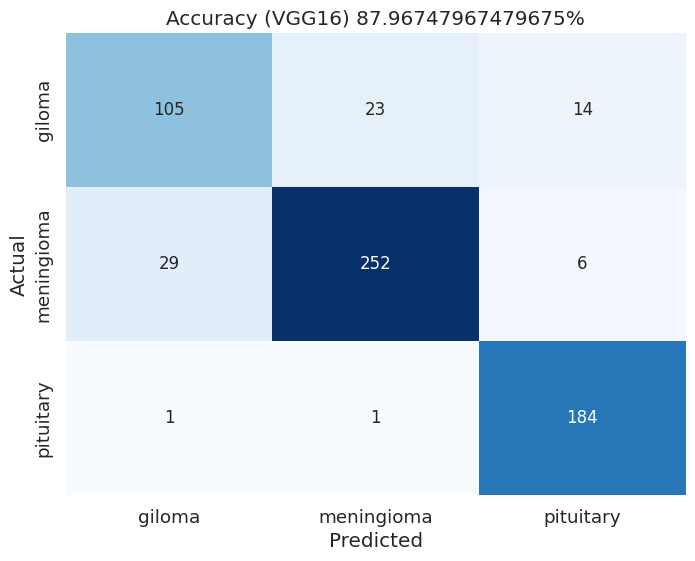

              precision    recall  f1-score   support

      giloma       0.78      0.74      0.76       142
  meningioma       0.91      0.88      0.90       287
   pituitary       0.90      0.99      0.94       186

    accuracy                           0.88       615
   macro avg       0.86      0.87      0.87       615
weighted avg       0.88      0.88      0.88       615



In [ ]:
# Plot heatmap confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12}, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Accuracy (VGG16) ' + str(metrics.accuracy_score(test_labels_encoded, test_labels_pred) * 100) + '%'
plt.title(title)
plt.show()

# Classification report dari conf matrixnya
print(classification_report(test_labels_encoded, test_labels_pred, target_names=class_labels))

In [1]:
!jupyter nbconvert --to html "./68637_NurfajriahOktaviani_SourceCode_UAS_IF540L" --output-dir="./"

[NbConvertApp] Converting notebook ./68637_NurfajriahOktaviani_SourceCode_UAS_IF540L.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 1030500 bytes to 68637_NurfajriahOktaviani_SourceCode_UAS_IF540L.html
